# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data.income[data.income == '>50K'].count()

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data.income[data.income == '<=50K'].count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100*float(n_greater_50k)/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

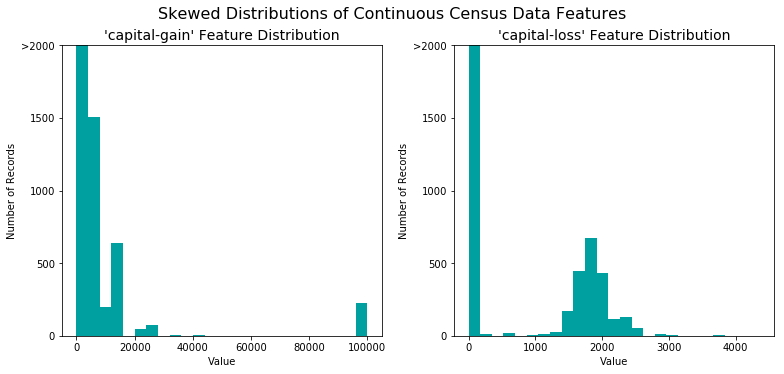

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

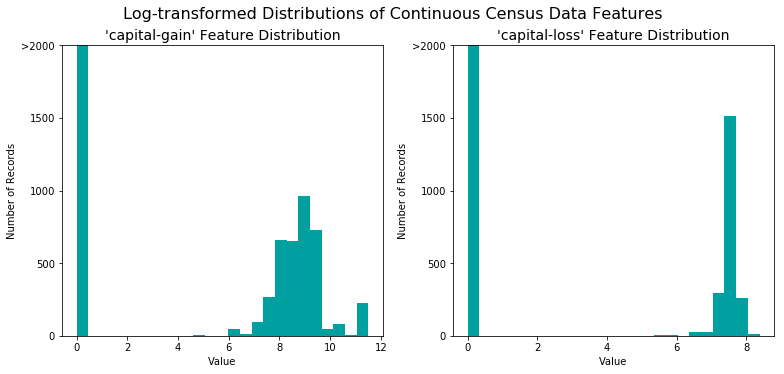

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = (income_raw == '>50K').astype(int)
#print income

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [9]:
#NOTE: Chose a model that always predicts  '>50K'
# TODO: Calculate accuracy
#(tp+tn)/(tp+tn+fp+fn)
#no negative guesses made, therefore same as precision
accuracy = float(n_greater_50k)/n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
betaSq = beta**2

#tp/(tp+fp)
precision = accuracy

#tp/(tp+fn)
#no negative guesses made, therefore =1
recall = 1

fscore = (1+betaSq)*precision*recall/(betaSq*precision+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **
In order to select the top 3 algorithms for this dataset I tested all of the above listed methods. I will therefore provide a brief description of why I did not select a particular method to be included in the top 3 and will answer all the above questions for the 3 selected methods. 



## Not Selected:
- GaussianNB: This algorithm trains very quickly (~0.2s for 100% of the data) yet predicts slightly slower in comparison to the selected algorithms. However in comparison to the selected algorithms it performs poorly before optimization (accuracy for training and testing: <=0.6, f-score for training and testing: <=0.4). I can not speak to its performance after optimization because I did not check to see which algorithm can be best optimized.

- DecisionTreeClassifier: This algorithm returns perfect accuracy and f scores for the training data, yet performs worse than the selected algorithms on the testing data. This is a clear indication that this model is overfitting to the training data and cannot generalize well (at least prior to optimization).  

- BaggingClassifier: Takes substantially longer than selected methods to train and predict. Performs similarly to DecisionTreeClassifier on the training data with marginally lower scores. Performs similarly to the selected algorithms on the testing data. The main reason this algorithm was not selected as one of the top 3 is due to the time it takes this model to train and predict. It seems to generalize well despite the high scores on the training data; however, there are quicker algorithms that generalize just as well, if not better. This algorithm may be a good candidate for optimization.

- RandomForestClassifier: Very similar to BaggingClassifier except that the time it takes to train the model is more reasonable.

- GradientBoostingClassifier: Takes an extremely long time to train this model (~16s for 100% of the data). Produces marginally better results than the selected methods. This model was not selected because the slight increase in the accuracy and f scores is not worth the time it takes to run the model.

- KNeighborsClassifier: Takes a relatively long time for this model to train (2.5s for 100% of the data) and predict (~40s for 100% of the data). This model does not produce better results than the 3 selected models. However, this model may be a good candidate for optimization although it would be difficult to get the training and testing times to reasonable values for this project.

- SGDClassifier: Relatively low training and prediciting times, but accuracy and f scores are lower than the 3 selected models.

- SVC: Takes an extremely long time to train (~170s for 100% of the data) and predict (30s for 100% of the data), which is not surprising based on this excerpt from the sklearn documentation, "The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples." The model also does not produce better results than the 3 selected models. Setting the kernel to 'linear' does not greatly increase performance. This reduces the time it takes to train 100% of the data by 30s and the time it takes to predict using 100% of the data by 5s. But with training and testing times so high and overall lower performance than the other algorithms it is not worth exploring this method further for this dataset.

## Selected:

### LinearSVC

**Industry Application:** SVMs have been used quite extensively in [bioinformatics research](https://en.wikipedia.org/wiki/Support_vector_machine#Applications). As a specific example, a SVC was trained using a linear kernel (among others) in an attempt to [identify neuropeptide precursors](bioinformatics.oxfordjournals.org/content/30/7/931.full.pdf).

**Strengths:**

- Excells at analyzing high dimensional spaces.
- LinearSVC uses liblinear as opposed to libsvm (what SVC uses) and therefore scales better when there are a large number of samples.
- SVMs are generally memory efficient


**Weaknesses:**

- Difficult to tune.
- Does not output probabilities.
- Does not perform well if the number of features is larger than the number of training samples.


**Justification for using:**
This algorithm is designed to perform classification for a large number of samples significantly quicker than SVC.


### LogisticRegression

**Industry Application:** There are numerous examples spanning many unrelated fields of logistic regression being used to make predictions. I found a journal article where the authors used logistic regression and principal component analysis to develop a [decision support tool for production planning and control](https://link.springer.com/article/10.1186/2251-712X-9-14). The idea is that this tool will improve the efficiency of production facilities by helping them deal with daily fluctuations and other unforseen events.

**Strengths:**
- Outputs probability of an event occuring given a particular set of input values.
- Resistant to noise.

**Weaknesses:**
- A large number of features can lead to overfitting
- Results must be, or must be transformed to be linearly seperable. This can cause the model to experience high bias. 

**Justification for using:** This algorithm is designed specifically for linearly separable classification problems and I do not believe the boundary between the two salary categories to be non-linear. This algorithm can also output the probability that a particular individual makes more than 50k, which could be useful (for instance it could be used to order the calls to potential donors from most likely to least likely to make over 50k).

### AdaBoostClassifier

**Industry Application:** This algorithm has been used to improve the accuracy of [cloud detection](http://iopscience.iop.org/article/10.1088/1755-1315/18/1/012026/pdf) in satellite images. It has also been implemented for [abdominal aortic aneurysm centerline detection](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3776471/) in an effort to better predict rupture risk.

**Strengths:** 
- Due to the mechanics of this method, the likelihood of overifitting is greatly reduced except for special cases.

**Weaknesses:**
- Susceptible to overfitting if there is uniform noise in the data.

**Justification for using:** 
Focuses on the samples that are difficult to classify. This should help increase the chances of properly classifying individuals that could easily fit into either salary category.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test, 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LinearSVC trained on 361 samples.
LinearSVC trained on 3617 samples.
LinearSVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


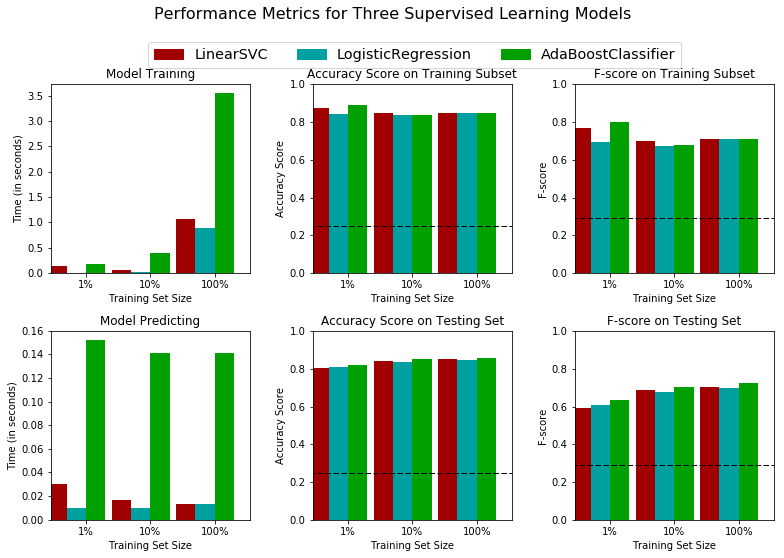

In [11]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models

clf_A = LinearSVC(random_state = 0, dual = False)
#From documentation: "Prefer dual=False when n_samples > n_features."

#clf_B = SGDClassifier(random_state = 0)
clf_B = AdaBoostClassifier(random_state = 0)
clf_C = LogisticRegression(random_state = 0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train)*0.01)
samples_10 = int(len(X_train)*0.1)
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** 

I believe that the AdaBoostClassifier is the most appropriate model to use for identifying individuals that earn more than 50k. Even though it is the slowest of the 3 algorithms it has the best accuracy and f scores for the training and testing data. An ensemble method is also ideal for this situation. According to the 2nd video on ensemble learning, these methods are used to take a number of "simple rules" and from that derive a more complex rule, which is essentially the situation in this project. It is also tunable, unlike LinearSVC, which was my initial "best model." More on this in the extra code section I added to the project.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

The AdaBoostClassifier is an ensemble method, which essentially means that it uses a collection (ensemble) of 'simple' models and systematically combines them in order to obtain one relatively robust and more complex model. In particular the AdaBoostClassifier continuously fits a user defined base_estimator (default is the DecisionTreeClassifier) to the training data where the weights of the improperly classified samples are adjusted on each successive fit in order to target the more difficult to classify examples. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state = 0)

# TODO: Create the parameters list you wish to tune

#parameters = {'base_estimator': [SVC]}
parameters = {'learning_rate': np.linspace(1.01,1.05,5), 'n_estimators': range(25,101,25)}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
#DELETE: need to create cv_sets??
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8628
Final F-score on the testing data: 0.7347


# Begin Extra Code

### Initially the three algorithms I was using were LinearSVC, LogisiticRegression, and the SGDClassifier. Linear SVC was the best performing of those 3 algorithms, but was essentially unable to be tuned. I wanted to experiment with an algorithm that could be tuned and decided to try out the AdaBoostClassifier. While doing this, I realized that the AdaBoostClassifier outperforms the SGDClassifier (in fact, in terms of accuracy and f scores it outperforms the other two algorithms). In an effort to attempt to identify the top 3 algorithms for this dataset it was therefore necessary for me to remove the SGDClassfier and replace it with the AdaBoostClassifier. This is why there is optimization code for LinearSVC below.

In [13]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state = 0)
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state = 0)

# TODO: Create the parameters list you wish to tune
#parameters = {'C': range(20,31,2)}
parameters = {'tol': [1e-20,1e-15,1e-10, 1e-7, 1e-6, 1e-5]}
#parameters = {'C': np.arange(0.2,0.31,0.02), 'tol': [1e-6, 1e-5, 1e-4]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
#DELETE: need to create cv_sets??
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8507
F-score on testing data: 0.7054

Optimized Model
------
Final accuracy score on the testing data: 0.8507
Final F-score on the testing data: 0.7054


# End of Extra Code

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.2478       |         0.8576    |       0.8628    |
| F-score        |        0.2917       |         0.7246    |       0.7347    |


**Answer: ** As expected the chosen model (in fact all models mentioned immediately before Question 2) outperforms the naive predictor. Unofortunately with an accuracy score and f score only 0.6% and 1.4% greater, resepectively,  the optimized model is not substantially better than the unoptimized model (although it is likely not optimally optimized). It would be interesting to explore optimization methods in order to tune the model more appropriately. In particular, it would be interesting to adjust the base_estimator parameter; however, this would be difficult to integrate with the pre-exisitng code as it is necessary to select the algorithm type (SAMME or SAMME.R) based on the model used for the base_estimator. At least the AdaBoostClassifier responds to tuning unlike LinearSVC as can be seen in the extra code above.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** 
1. Age - Generally someone who is older has more experience in their field, giving them the ability to demand a higher salary. They also likely have higher valued investments and have received more raises, promotions, and other such perks that come with being in the workforce for a longer time than their younger peers.

2. Education Level - Generally a higher degree is indicative of a higher salary.

3. Capital Gain - To have capital gains one must have money to invest. The more capital one has to invest, the higher the chance of an individual having a higher value for this paramter. Therefore, a higher number for this parameter would indicate a higher probability of earning more than 50k.

4. Hours per Week - For hourly employees, this number is directly correlated to their income. But how was this number recorded for salaried individuals? If an individual is salaried was it assumed that they work 40 hr/wk or was the individual free to report the average number of hours they work per week? If they were free to report more than 40 hr/wk, did some individuals include time spent managing their investment accounts, freelancing, etc. as part of their hours per week? I estimate that there is likely a boundary around 30 hr/wk above which it is more likely for an individual to earn more than 50k and below which it is more likely for an individual to earn less than 50k. Of course there will be outliers on both ends of the spectrum. For instance K-12 educators often work more than 40 hr/wk, yet unfortunately many do not make greater than 50k. There are also freelancers that work significantly less than 40 hr/wk yet earn far more than 50k.

5. Occupation - I am hestitant to consider this relevant based on the poorly defined [categories](https://archive.ics.uci.edu/ml/datasets/Census+Income) (UCI ML link from the "Getting Started" section). It seems that some 'high salary' occupations are going to be forced into non-descriptive or 'catch all' categories such as Prof-specialty, Exec-managerial, and Other-service. Assuming there is a well defined method for placing occupations that do not easily fit into the predefined categories and assuming this was followed without interpretation by all the data collectors, I think it is feasible that this parameter could help the model select individuals that make more than 50k. However, if this parameter had more well-defined categories I believe it would be a much stronger indicator.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

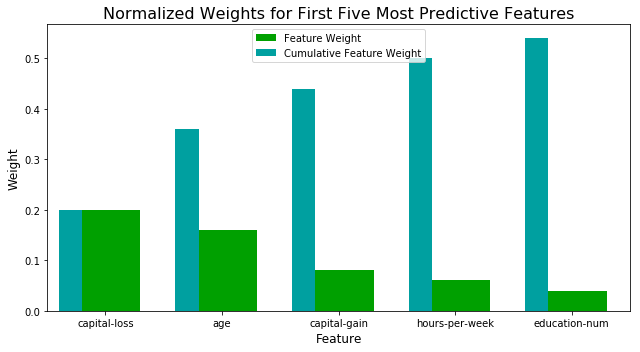

In [14]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** 

Initially I found it particularly interesting that capital-loss is such an important feature. However, after giving it some thought this is somewhat justifiable. Let's begin by defining two different types of investors on opposite ends of the spectrum.

**High Risk:** Makes high risk and short term investments based on "tips," gossip, gut feelings, etc. and does not do their own research. Makes long term investments solely based on "brand names." Investments are not well-diversified. Frequently attempts to time markets. Looks for the markets to "work for them." Trades with the herd and is an emotional investor; more likely to purchase an investment when they see that particular investment (whether it be real estate in a a neighborhood or equity in a company) is highly valued and sell an investment when it begins to lose value. This type of person can get "lucky" and "make it big"; however, it is far more likely that this type of person consistently experiences capital loss.

**Low Risk:** Does significant research prior to making any investment whether it is in a penny stock, Fortune 500 company, real estate, etc. Maintains a diversified portfolio and understands industry trends. Understands the cyclical nature of markets. Tests personal and/or researched strategies prior to implementing them using larger amounts of capital. Not afraid of loss, sees it as an opportunity to learn; however, they would never put themselves in a position to lose enough to become financially crippled. This type of person may get lucky with an investment as well; however, they are far more likely to experience less capital loss and more long term capital gains over time. 

Based on the definitions above, I postulate that Low Risk investors overall are generally wealthier or will become wealthier because they have cetain personality traits and habits that are generally indicators for success, whereas a High Risk investor shares traits found in gamblers. Therefore, my assumption is that generally a lower, non-zero capital loss score will help identify individuals that earn greater than 50k. A capital loss of 0 could indicate an individual that does not invest (regardless of what they earn), an exceedingly savvy investor, or an investor that did not sell any of their investements that would have caused them to incur a capital loss and is therefore highly indeterminate without additional information. Very high capital losses could indicate a wealthy High Risk investor. My hypothesis is therefore only valid for investors that do not stray terribly far from the mean value for capital loss in either direction.

-Education level is replaced with education-num and is the least important of the 5 features. The number of years spent in school is a stronger indicator of an individual's possible major and therefore earning power than the level of the degree obtained. This could also be seen as an indictor of an individual's determination and drive. A driven person that struggles with some coursework is more likely to repeat a course or take longer to graduate with a more esteemed degree than someone who wants to just get a degree because it's what they've been taught they need to do to get a job. A driven person is more likely to excel in the workforce and therefore is more likely to earn more than 50k. I'm guessing that this also could be an indicator for non-traditional students that worked full time while going to school.

-Occupation is unsurprisingly not included in the top 5 parameters. This is likely due to the reasons listed in Question 6.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8507
F-score on testing data: 0.7054

Final Model trained on reduced data
------
Accuracy on testing data: 0.8097
F-score on testing data: 0.5986


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** The accuracy score decreases by 0.041 or 4.8% and the F-score decreases by 0.1068 or 13.2% when the reduced data model is used. Taking this into account I would be hesitant to use the reduced data model even if training time were a factor. An analysis would need to be run to determine whether the additional training time is worth the time saved calling potential donors. Perhaps using the top 6 or 7 features would produce a model with less dramatic decreases in the accuracy and f scores.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.